In [103]:
import yaml
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pickle
import numpy as np
import networkx as nx

with open(r"./configs/build_taxo.yml") as file:
    params_list = yaml.load(file, Loader=yaml.FullLoader)

In [9]:
class TaxonomyBuilder:
    def __init__(self, root, all_verteces, max_iter=10000):
        self.root = root
        self.all_verteces = all_verteces
        self.max_iter = max_iter

    def build_taxonomy(self, strategy, **kwargs):
        self.edge_collector = getattr(self, strategy)
        self.collector_params = kwargs

        # self.pbar = tqdm(total=34000)
        self.all_edges = []
        self.i = 0
        self.build_tree(self.root, self.all_verteces)
        # self.pbar.close()

    #   return self.all_edges

    def build_tree(self, root, possible_verteces):
        top_edges_idx = self.edge_collector(
            root, possible_verteces, **self.collector_params
        )
        new_pos_verteces = np.delete(possible_verteces, top_edges_idx)
        for new_edge_idx in top_edges_idx:
            self.all_edges.append((root, possible_verteces[new_edge_idx]))
            # self.pbar.update(1)
            self.i += 1
            if self.i > self.max_iter:
                break
            self.build_tree(possible_verteces[new_edge_idx], new_pos_verteces)

    @staticmethod
    def ppl_thr_collector(root, possible_verteces, **kwargs):
        ppls = np.array(
            [kwargs["ppl_pairs"][(root, vertex)] for vertex in possible_verteces]
        )
        return np.where(np.array(ppls) < kwargs["thr"])[0]

    @staticmethod
    def ppl_top_collector(root, possible_verteces, **kwargs):
        ppls = np.array(
            [kwargs["ppl_pairs"][(root, vertex)] for vertex in possible_verteces]
        )
        return np.argsort(ppls)[: min(kwargs["top_k"], len(ppls))]


def clean_dict(pairs, use_lemma, reverse):
    new_pairs = {}
    for key, val in pairs.items():
        if use_lemma:
            term = key[0].split("(")[0].strip()
        else:
            term = key[0]
        target = key[1].split(",")[0]
        new_key = (target, term) if reverse else (term, target)
        new_pairs[new_key] = val

    return new_pairs


def iterative_child(ppl_pairs, low, high, step, max_iter):
    thrs = np.arange(low, high, step)
    Fs = []
    for thr in tqdm(thrs):
        tb = TaxonomyBuilder(root, all_verteces, max_iter)
        tb.build_taxonomy("ppl_thr_collector", ppl_pairs=ppl_pairs, thr=thr)
        edges = tb.all_edges

        P = len(set(G.edges()) & set(edges)) / (len(set(edges)) + 1)
        R = len(set(G.edges()) & set(edges)) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)

        #  print('precision: {} \n recall: {} \n F-score: {}'.format(P,R,F))
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs


def brute_child(ppl_pairs, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    for thr in tqdm(thrs):
        edges = []
        for key, val in ppl_pairs.items():
            if val < thr:
                edges.append(key)

        P = len(set(G.edges()) & set(edges)) / (len(set(edges)) + 1e-15)
        R = len(set(G.edges()) & set(edges)) / len(set(G.edges()))
        # print(len(set(edges)))
        F = (2 * P * R) / (P + R + 1e-15)

        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs

In [5]:
def get_graph(ppl_pairs, thr):
    S = nx.DiGraph()
    for key, val in ppl_pairs.items():
        if val <thr:
            S.add_edge(key[0], key[1], weight=val)
    return S
        

In [99]:
def brute_resolve(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
    
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = ppl_reverse[(edge[1], edge[0])]
                    ppls[edge] = weight_reverse
                
                if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()):

                    max_ppl_key = max(ppls, key=ppls.get) 
                    # print(edges_q)
                    # print(ppls.keys())
                    # print(ppls.values())
                    # print(max_ppl_key)
                    counter +=1
                    S.remove_edge(*max_ppl_key)

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts


100%|███████████████████████████████████████| 2990/2990 [01:45<00:00, 28.30it/s]


0.13365735115431304 5.389999999999997


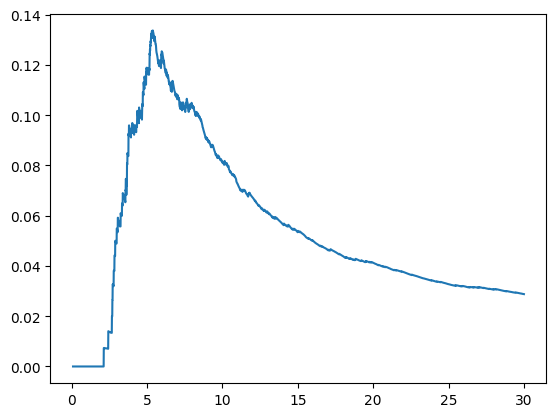

In [100]:
if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=reverse)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res1, counter = brute_resolve(ppls_pairs, ppl_reverse, low=low, high=high, step=step)


In [101]:
max(counter)

15

100%|██████████████████████████████████████| 2990/2990 [00:27<00:00, 109.24it/s]


0.13510253317249654 5.389999999999997


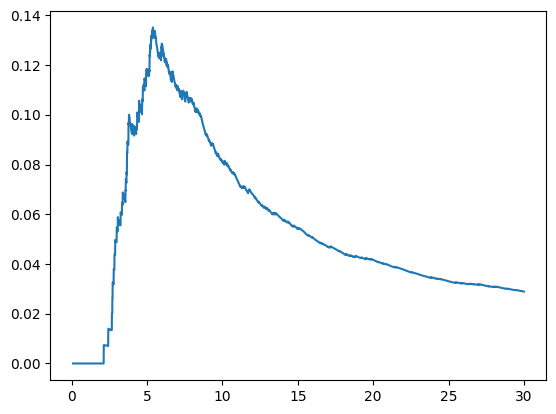

In [97]:
res = brute_child(ppls_pairs, low=low, high=high, step=step)

In [98]:
max(res)

0.13510253317249654

100%|███████████████████████████████████████| 2990/2990 [02:25<00:00, 20.55it/s]


0.4026548672566367 2.489999999999999


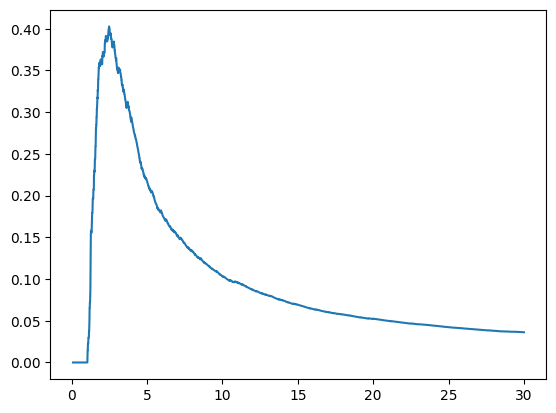

In [104]:
if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=False)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res1, counter = brute_resolve(ppls_pairs, ppl_reverse, low=low, high=high, step=step)

In [105]:
max(counter)

53

In [ ]:
def brute_resolve_summation(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
    
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = ppl_reverse[(edge[1], edge[0])]
                    ppls[edge] = weight_reverse
                
                if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()):

                    max_ppl_key = max(ppls, key=ppls.get) 
                    # print(edges_q)
                    # print(ppls.keys())
                    # print(ppls.values())
                    # print(max_ppl_key)
                    counter +=1
                    S.remove_edge(*max_ppl_key)

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts